In [1]:
!pip install pytorch_ood

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.4/156.4 kB 14.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 927.3/927.3 kB 36.7 MB/s eta 0:00:00


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Subset, DataLoader, random_split
import numpy as np
from pytorch_ood.model import WideResNet
from torch.optim.lr_scheduler import StepLR
from collections import Counter
from pytorch_ood.detector import MultiMahalanobis, MCD
import matplotlib.pyplot as plt
from PIL import Image

# Configuration and hyperparameters
RANDOM_SEED = 42
DEPTH = 28
WIDEN_FACTOR = 10
DROPOUT_RATE = 0.3
EXCLUDE_CLASS = 'airplane'
NUM_EPOCHS = 50
LEARNING_RATE = 0.1
BATCH_SIZE = 128
TEST_BATCH_SIZE = 100
VALIDATION_SPLIT = 0.2
FILE_PATH = ' '

# Set random seeds for reproducibility
torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

# CIFAR10 class names
CLASSES = ['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']

Functions

Run these functions

In [6]:
def count_samples_per_class(dataset, classes, exclude_class):
  """
  Count the number of samples for each class in the dataset, excluding a specified class.

  Args:
      dataset: The input dataset to analyze
      classes: List of all possible classes
      exclude_class: The class to exclude from counting

  Returns:
      dict: Dictionary with class names as keys and sample counts as values
  """
  filtered_classes = [c for c in classes if c != exclude_class]
  class_counts = {cls: 0 for cls in filtered_classes}

  for _, label in dataset:
      # Adjust label index to account for excluded class
      adjusted_label = label if label < classes.index(exclude_class) else label - 1
      class_counts[filtered_classes[adjusted_label]] += 1

  return class_counts

def setup_data_loaders_cifar_10(exclude_class):
  """
  Set up PyTorch data loaders for CIFAR-10 dataset with one class excluded.
  Handles data transformation, class exclusion, and label remapping.

  Args:
      exclude_class: The class to exclude from the dataset

  Returns:
      tuple: (train_loader, val_loader, test_loader, exclude_index)
          - train_loader: DataLoader for training data
          - val_loader: DataLoader for validation data
          - test_loader: DataLoader for test data
          - exclude_index: Index of the excluded class
  """
  # Define standard CIFAR-10 transformations
  transform = transforms.Compose([
      transforms.RandomCrop(32, padding=4),
      transforms.RandomHorizontalFlip(),
      transforms.ToTensor(),
      transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
  ])

  # Load full datasets
  full_trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
  full_testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

  # Get index of class to exclude
  exclude_index = CLASSES.index(exclude_class)

  # Create label mapping for remaining classes
  label_mapping = {}
  new_label = 0
  for old_label in range(len(CLASSES)):
      if old_label != exclude_index:
          label_mapping[old_label] = new_label
          new_label += 1

  # Custom dataset class for handling label remapping
  class RemappedSubset(torch.utils.data.Dataset):
      """Custom dataset class that remaps class labels after excluding a class"""
      def __init__(self, dataset, indices, mapping):
          self.dataset = dataset
          self.indices = indices
          self.mapping = mapping

      def __getitem__(self, idx):
          image, label = self.dataset[self.indices[idx]]
          return image, self.mapping[label]

      def __len__(self):
          return len(self.indices)

  # Filter out excluded class and create new datasets
  train_indices = [i for i, (_, label) in enumerate(full_trainset) if label != exclude_index]
  test_indices = [i for i, (_, label) in enumerate(full_testset) if label != exclude_index]

  train_subset = RemappedSubset(full_trainset, train_indices, label_mapping)
  test_subset = RemappedSubset(full_testset, test_indices, label_mapping)

  # Split training data into training and validation sets
  train_size = int(len(train_subset) * (1 - VALIDATION_SPLIT))
  val_size = len(train_subset) - train_size
  train_subset, val_subset = random_split(train_subset, [train_size, val_size])

  # Create and return data loaders
  train_loader = DataLoader(train_subset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
  val_loader = DataLoader(val_subset, batch_size=TEST_BATCH_SIZE, shuffle=False, num_workers=2)
  test_loader = DataLoader(test_subset, batch_size=TEST_BATCH_SIZE, shuffle=False, num_workers=2)

  return train_loader, val_loader, test_loader, exclude_index

def create_model():
  """
  Create and initialize a WideResNet model for classification.

  Returns:
      tuple: (model, device)
          - model: Initialized WideResNet model
          - device: torch device (cuda if available, else cpu)
  """
  model = WideResNet(
      depth=DEPTH,
      num_classes=9,  # One less than CIFAR-10 due to excluded class
      widen_factor=WIDEN_FACTOR,
      drop_rate=DROPOUT_RATE
  )
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  model = model.to(device)
  return model, device

def train(model, train_loader, val_loader, criterion, optimizer, device, exclude_index):
  """
  Train the model and perform validation.

  Args:
      model: The model to train
      train_loader: DataLoader for training data
      val_loader: DataLoader for validation data
      criterion: Loss function
      optimizer: Optimization algorithm
      device: torch device
      exclude_index: Index of excluded class

  Returns:
      float: Validation loss
  """
  # Training phase
  model.train()
  train_loss = 0
  train_correct = 0
  train_total = 0

  for batch_idx, (inputs, targets) in enumerate(train_loader):
      inputs, targets = inputs.to(device), targets.to(device)

      optimizer.zero_grad()
      outputs = model(inputs)
      loss = criterion(outputs, targets)
      loss.backward()
      optimizer.step()

      train_loss += loss.item()
      _, predicted = outputs.max(1)
      train_total += targets.size(0)
      train_correct += predicted.eq(targets).sum().item()

  # Validation phase
  model.eval()
  val_loss = 0
  val_correct = 0
  val_total = 0

  with torch.no_grad():
      for inputs, targets in val_loader:
          inputs, targets = inputs.to(device), targets.to(device)

          outputs = model(inputs)
          loss = criterion(outputs, targets)

          val_loss += loss.item()
          _, predicted = outputs.max(1)
          val_total += targets.size(0)
          val_correct += predicted.eq(targets).sum().item()

  # Print training and validation statistics
  print(f'Train Loss: {train_loss/len(train_loader):.3f} | '
        f'Train Acc: {100.*train_correct/train_total:.3f}%')
  print(f'Val Loss: {val_loss/len(val_loader):.3f} | '
        f'Val Acc: {100.*val_correct/val_total:.3f}%')

  return val_loss / len(val_loader)

def create_ood_loader(exclude_class, batch_size=128):
  """
  Create a DataLoader for out-of-distribution (OOD) data using the excluded class.

  Args:
      exclude_class: The class to use as OOD data
      batch_size: Batch size for the DataLoader

  Returns:
      DataLoader: DataLoader containing only samples from the excluded class
  """
  # Define transformations matching the main dataset
  transform = transforms.Compose([
      transforms.RandomCrop(32, padding=4),
      transforms.RandomHorizontalFlip(),
      transforms.ToTensor(),
      transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
  ])

  full_trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
  exclude_index = CLASSES.index(exclude_class)

  # Custom dataset for OOD samples
  class OODDataset(torch.utils.data.Dataset):
      """Dataset containing only samples from the excluded class"""
      def __init__(self, dataset, exclude_index):
          self.dataset = dataset
          self.indices = [i for i, (_, label) in enumerate(dataset) if label == exclude_index]

      def __getitem__(self, idx):
          return self.dataset[self.indices[idx]]

      def __len__(self):
          return len(self.indices)

  ood_dataset = OODDataset(full_trainset, exclude_index)
  return DataLoader(ood_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

def get_detector(detector_name, model, device, train_loader, val_loader, test_loader):
  """
  Create and initialize an OOD detector based on the specified method.

  Args:
      detector_name: Name of the detector ('Mahalanobis' or 'Monte Carlo')
      model: Trained model
      device: torch device
      train_loader: DataLoader for training data
      val_loader: DataLoader for validation data
      test_loader: DataLoader for test data

  Returns:
      detector: Initialized OOD detector
  """
  if detector_name == 'Mahalanobis':
      # Extract layers for Mahalanobis detector
      layer1 = model.conv1
      layer2 = model.block1
      layer3 = model.block2
      layer4 = model.block3

      class MyLayer(nn.Module):
          def __init__(self, bn1, relu):
              super(MyLayer, self).__init__()
              self.bn1 = bn1
              self.relu = relu

          def forward(self, x):
              x = self.bn1(x)
              x = self.relu(x)
              return x

      layer5 = MyLayer(model.bn1, model.relu)
      detector = MultiMahalanobis([layer1, layer2, layer3, layer4, layer5])
      detector.fit(train_loader, device=device)
      return detector

  elif detector_name == "Monte Carlo":
    #Amount of samples can be changed for more robust performance. The more samples, the better the detector
      return MCD(model, samples=30)
  else:
      raise ValueError(f"Unknown detector name: {detector_name}")

def run_and_visualize(detector, test_loader, ood_loader, device, visualization=False, plot_scores=False):
  """
  Run OOD detection on test and OOD data and visualize results.

  Args:
      detector: OOD detector
      test_loader: DataLoader for in-distribution test data
      ood_loader: DataLoader for out-of-distribution data
      device: torch device
      visualization: If True, print example predictions
      plot_scores: If True, plot score distributions

  Returns:
      tuple: (id_scores, id_labels, ood_scores, ood_labels)
  """
  id_scores = []
  id_labels = []
  ood_scores = []
  ood_labels = []

  # Process in-distribution data
  print("Processing In-Distribution Data:")
  for i, (x, y) in enumerate(test_loader):
      result = detector.predict(x.to(device))
      id_scores.extend(result.cpu().numpy())
      id_labels.extend(y.cpu().numpy())

      if visualization and i < 10:
          for j in range(min(len(y), 10)):
              print(f"Target Label: {y[j]}, OOD Score: {result[j]:.4f}")

  # Process out-of-distribution data
  print("Processing Out-of-Distribution Data:")
  for i, (x, y) in enumerate(ood_loader):
      result = detector.predict(x.to(device))
      ood_scores.extend(result.cpu().numpy())
      ood_labels.extend(y.cpu().numpy())

      if visualization and i < 10:
          for j in range(min(len(y), 10)):
              print(f"Target Label: {y[j]} (OOD), OOD Score: {result[j]:.4f}")

  if plot_scores:
      plot_score_distributions(id_scores, ood_scores)

  return id_scores, id_labels, ood_scores, ood_labels

def plot_score_distributions(id_scores, ood_scores):
  """
  Plot histograms comparing the distribution of OOD scores for in-distribution
  and out-of-distribution data.

  Args:
      id_scores: List of scores for in-distribution samples
      ood_scores: List of scores for out-of-distribution samples
  """
  plt.figure(figsize=(10, 6))
  plt.hist(id_scores, bins=50, density=True, alpha=0.6, color='blue',
            label='In-Distribution')
  plt.hist(ood_scores, bins=50, density=True, alpha=0.6, color='red',
            label='Out-of-Distribution')

  plt.xlabel('OOD Score')
  plt.ylabel('Density')
  plt.title('Distribution of OOD Scores')
  plt.legend()

  # Add mean lines
  plt.axvline(np.mean(id_scores), color='blue', linestyle='dashed', alpha=0.5)
  plt.axvline(np.mean(ood_scores), color='red', linestyle='dashed', alpha=0.5)

  plt.show()

def single_image_inference(img_path, detector):
  """
  Perform OOD detection on a single input image.

  Args:
      img_path: Path to the input image file
      detector: OOD detector model
  """
  # Load the image
  file_path = str(img_path)
  custom_image = Image.open(file_path).convert('RGB')

  # Create the transformation pipeline
  transform = transforms.Compose([
      transforms.Resize((32, 32)),  # First resize to CIFAR-10 dimensions
      transforms.RandomCrop(32, padding=4),
      transforms.RandomHorizontalFlip(),
      transforms.ToTensor(),
      transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
  ])

  # Apply transformation
  custom_image_tensor = transform(custom_image)

  # Add a batch dimension (CIFAR-10 batches are [N, 3, 32, 32])
  custom_image_tensor = custom_image_tensor.unsqueeze(0)  # Shape: [1, 3, 32, 32]

  # Ensure the device matches the detector
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  custom_image_tensor = custom_image_tensor.to(device)

  # Perform prediction
  result = detector.predict(custom_image_tensor)
  print(f"Prediction result for the custom image: {result}")


  # Display the image
  plt.imshow(custom_image)
  plt.axis("off")
  plt.show()

Training



In [6]:
train_loader, val_loader, test_loader, exclude_index = setup_data_loaders_cifar_10(EXCLUDE_CLASS)

# Print sample counts for training set
print("Sample Counts per Class in Training Set:")
full_trainset = train_loader.dataset.dataset
class_counts = count_samples_per_class(full_trainset, CLASSES, EXCLUDE_CLASS)
for cls, count in class_counts.items():
  print(f"{cls}: {count}")

# Create model
model, device = create_model()

# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=0.9, weight_decay=5e-4)

# Learning rate scheduler
scheduler = StepLR(optimizer, step_size=10, gamma=0.1)

# Training loop
print(f"Training WideResNet (depth={DEPTH}, widen_factor={WIDEN_FACTOR}) "
  f"on CIFAR10 excluding {EXCLUDE_CLASS} class")
best_val_loss = float('inf')

for epoch in range(NUM_EPOCHS):
  print(f"Epoch {epoch+1}/{NUM_EPOCHS}")

  # Train and validate for one epoch
  val_loss = train(model, train_loader, val_loader, criterion, optimizer, device, exclude_index)

  # Step the learning rate
  scheduler.step()

  # Save best model based on validation loss
  if val_loss < best_val_loss:
    best_val_loss = val_loss
    torch.save(model.state_dict(), FILE_PATH)

# Load best model for final testing
model.load_state_dict(torch.load(FILE_PATH))



# print(f"Best Test Accuracy: {best_acc:.2f}%")
print(f"Best model saved as {FILE_PATH}'")

100%|██████████| 170M/170M [00:02<00:00, 72.0MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified

Label Remapping Verification:
Original labels: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Excluded class index: 0
Label mapping: {1: 0, 2: 1, 3: 2, 4: 3, 5: 4, 6: 5, 7: 6, 8: 7, 9: 8}

New label assignments:
automobile: 0
bird: 1
cat: 2
deer: 3
dog: 4
frog: 5
horse: 6
ship: 7
truck: 8

Dataset sizes:
Full training set (before exclusion): 50000
Training set (after exclusion): 36000
Validation set: 9000
Test set (after exclusion): 9000

Verifying labels in training set:
Unique labels in training set: [0, 1, 2, 3, 4, 5, 6, 7, 8]
Sample Counts per Class in Training Set:
automobile: 5000
bird: 5000
cat: 5000
deer: 5000
dog: 5000
frog: 5000
horse: 5000
ship: 5000
truck: 5000
Training WideResNet (depth=28, widen_factor=10) on CIFAR10 excluding airplane class
Epoch 1/50


KeyboardInterrupt: 

Inference

Files already downloaded and verified
Files already downloaded and verified
Label Remapping Verification:
Original labels: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Excluded class index: 0
Label mapping: {1: 0, 2: 1, 3: 2, 4: 3, 5: 4, 6: 5, 7: 6, 8: 7, 9: 8}
New label assignments:
automobile: 0
bird: 1
cat: 2
deer: 3
dog: 4
frog: 5
horse: 6
ship: 7
truck: 8
Dataset sizes:
Full training set (before exclusion): 50000
Training set (after exclusion): 36000
Validation set: 9000
Test set (after exclusion): 9000
Verifying labels in training set:
Unique labels in training set: [0, 1, 2, 3, 4, 5, 6, 7, 8]
Files already downloaded and verified
OOD Dataset Statistics:
Number of OOD samples: 1000
OOD class: airplane (index 0)
calculating variance
Prediction result for the custom image: tensor([4.6580e-06])


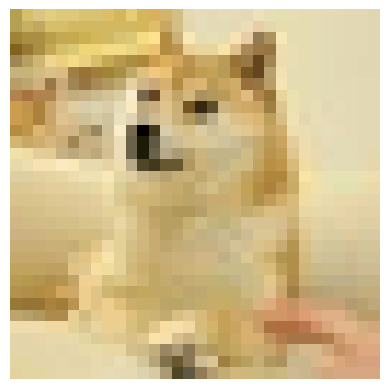

In [5]:
def main():
  model, device = create_model()

  model.load_state_dict(torch.load(FILE_PATH, weights_only=True))


  # Setup data loaders
  train_loader, val_loader, test_loader, exclude_index = setup_data_loaders_cifar_10(EXCLUDE_CLASS)
  ood_loader = create_ood_loader(EXCLUDE_CLASS)

  # Create detector
  detector = get_detector('Monte Carlo', model, device, train_loader, val_loader, test_loader)

  # Run detection and visualization
  id_scores, id_labels, ood_scores, ood_labels = run_and_visualize(
      detector=detector,
      test_loader=test_loader,
      ood_loader=ood_loader,
      device=device,
      visualization=True,  # Set to False to skip example printing
      plot_scores=True    # Set to False to skip distribution plotting
  )
  # single_image_inference(img_path="/content/dogetokenbase_32.png", detector=detector)

if __name__ == "__main__":
  main()